# TOOL EXAMPLES

This worksheet contains examples of tool use and CodeAct pattern.

There are 4 examples:
1. Data Analysis Assistance:  Demonstrates using a coding tool which reads and analyses content of a csv file.
2. Research Query Engine:  Demonstrates using a search engine tool Tavily to retrieve information.
3. Website Tester:  Uses coding and playwright to perform testing on a website.
4. Database CodeAct:  Demonstrates the CodeAct pattern to access a database.

In [2]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState
from langchain.tools import tool
#from langchain_community.tools.file_management.read import ReadFileTool
#from langchain_experimental.tools.python.tool import PythonREPLTool
from pydantic import BaseModel, Field
from IPython.display import display, HTML, Image
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
import os
import json
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)
import subprocess

from langgraph.graph.message import add_messages 

import pandas as pd

## 1. Data Analysis Assistant (Code Execution)

Purpose: Automate a small data analysis task — e.g. summarising a CSV or calculating averages.

Pattern(s): CodeAct – the LLM decides when to write and execute Python code.
Tools / Nodes:

 code_execution node

FileTool for reading uploaded CSVs

Human node for user confirmation

In [3]:
# Example 1

# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)


# STATE
class ExecutionState(BaseModel):
    # Use add_messages Reducer to accumulate messages
    messages: Annotated[list[AnyMessage], add_messages]
    
    
# TOOLS
# code execution tool
import contextlib
import io
@tool
def execute_code(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message.
        You have access to the pandas library."""
    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code)
        result = f.getvalue()    
    except Exception as e:
            result = f"Error: {e}"
    return result



# NODE
def generate_code_node(state: ExecutionState) -> dict:
    
    # bind the tool to the llm
    execution_llm = llm.bind_tools([execute_code])    
    # invoke the llm with messages passed via the state
    result = execution_llm.invoke(state.messages)
    # return result for LangGraph to update against the messages field of the state
    return {"messages": result}


# GRAPH
graph = StateGraph(ExecutionState)
graph.add_node("code", generate_code_node)
graph.add_node("execute", ToolNode(tools=[execute_code]))

graph.add_edge(START, "code")
graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"}) 
graph.add_edge("execute", "code")


data_analysis_graph = graph.compile()


# INSTRUCTIONS
system_message = """
You are an expert Python programmer and data scientist.
You will be provided with a file path to a csv file and your task is to analyze the data in the file.
"""
instruction_message = """
You are required to analyse the following csv file: {file_path}
Write a python script to perform the following tasks:
1. Read the csv file and list the column names and types.
2. Compute the average of the numeric columns.
3. If there are any categorical columns, compute the frequency of each category.
"""


## EXECUTION
messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(file_path="crm.csv")) ]

result = data_analysis_graph.invoke(ExecutionState(messages=messages))

E0000 00:00:1766508261.721750    4878 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


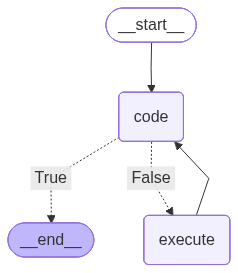

In [4]:
data_analysis_graph

# 2. Research Query Engine (Search Tools)

Purpose: Answer user questions using real-time web or API data.
Tool:  Tavily search and extraction tool

Workflow:  Query Web -> Get Results -> Summarize Results

Note that you will need create an account with Tivily and install the package below in uv:
- uv add tavily-python


In [2]:
from tavily import TavilyClient

In [4]:
# Example 2

# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)

tavily_client = TavilyClient(api_key=os.getenv("TAVILI_API_KEY"))


# STATE
class SearchState(BaseModel):
    query: str
    messages: Annotated[list[AnyMessage], add_messages] = []
    
    
# TOOLS
@tool
def tavili_search_tool(query: str = Field(description="Query for internet search with Tavily")) -> str:
    """Searches Tavili and returns the top result."""
    try:
        result = json.dumps(tavily_client.search(query=query)['results'])
    except Exception as e:
        result = f"Error(tavili_search_tool) : {e}"
    return "<SEARCH RESULTS>" + result + "</SEARCH RESULTS>"


# NODES
def search_query(state: SearchState) -> dict:
    messages = [SystemMessage(content="You are a helpful assistant that helps users find information."),
                HumanMessage(content=state.query)]
    
    result = llm.bind_tools(tools=[tavili_search_tool]).invoke(messages)
    return {"messages": result}

def summary_node(state: SearchState) -> dict:
    """Summarizes the search results."""
    messages = [SystemMessage(content="You are a helpful assistant that summarizes internet search results."),
                HumanMessage(content=f"Summarize the following search results for the query: {state.query}\n {state.messages[-1].content}")]
    try:
        summary = llm.invoke(messages)
        return {"messages": summary}
    except Exception as e:
        error_message = f"Error(summary_node) : {e}"
        return {"messages": [AIMessage(content=error_message)]}

    
# GRAPH
graph = StateGraph(SearchState)
graph.add_node("query", search_query)
graph.add_node("search", ToolNode(tools=[tavili_search_tool]))
graph.add_node("summary", summary_node)

graph.add_edge(START, "query")
graph.add_edge("query", "search")
graph.add_edge("search", "summary")
graph.add_edge("summary", END)

tavili_search_graph = graph.compile()


#result = tavili_search_graph.invoke(SearchState(query="What is XR?"))
result = tavili_search_graph.invoke(SearchState(query="4 Bed houses sold in Stepaside Dublin in 2024"))
print(result['messages'][-1].content)


E0000 00:00:1765882872.130077    6537 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Based on the search results, here's a summary of 4-bedroom houses sold in Stepaside, Dublin in 2024:

*   **13 Belarmine Court, Stepaside, Dublin 18:** This terraced house with 4 bedrooms and 4 bathrooms, measuring 151.0 m², was sold on December 6, 2024, for €711,000 (asking price was €645,000).
*   **5 Cairnfort, Enniskerry Rd, Stepaside Dublin 18:** This detached house with 4 bedrooms and 4 bathrooms, measuring 230.0 m², was sold on December 5, 2025 (note: this date appears to be in the future, likely a typo in the source). The sold price was €990,000 (asking price was €945,000).
*   **4 Cairnfort, Stepaside, Dublin 18:** This is a large four-bedroom detached house extending to 200 Sq.m/2,153 Sq.ft. It is wired for EV charging and has an attic room currently used as a study. While this listing is from Hunters Estate Agent, it doesn't explicitly state it has been sold in 2024, but it is described as a property in Stepaside.

It's important to note that one of the listed sales dates (D

## 3. Web Site Tester

- Purpose:  Read and navigate web page, enter into form and read result
- Tool:  Playwright

- Pattern:  ReAct

Notes:
- Need to run website (web_app.py and templates)
This was prompt give to Copilot to generate website: \
"I want a simple web application for a demonstration. The app should use flask and may use jinja. All pages should be build server since with html only in the browser. The app should show a list of contacts. Each contact should have: name, email and phone. There should be two pages in the application: 'list contacts' and 'add contacts'. The 'list contacts' should be an html table and the 'add contacts' should be an html form. There should be a menu bar to navigate between the two pages. The data should be stored in a sqlite database. Use bootstrap for formatting."
- Need to uv add playwright then run:  >uv run playwright install
- 

In [13]:
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)


# STATE
class TestingState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

# TOOLS
import contextlib
import io
import playwright
import sys
@tool
def execute_code(code: str = Field(description="Code to be executed.")) -> str:
    """
    Execute the Python code and returns the output or error message.
    The playwright library is available for web interactions.
    You must use the playwright async library as this runs in Jupyter
    """
    """Run Python source in a fresh subprocess that inherits the current environment."""
    if not isinstance(code, str):
        raise TypeError("code must be a string")
    completed = subprocess.run(
        [sys.executable, "-c", code],
        capture_output=True,
        text=False,
        check=False,
        env=os.environ.copy(),
    )
    stdout = completed.stdout.decode("utf-8", errors="replace") if completed.stdout else ""
    stderr = completed.stderr.decode("utf-8", errors="replace") if completed.stderr else ""
    if completed.returncode != 0:
        detail = f"{stdout}{stderr}".strip()
        return f"Process exited with status {completed.returncode}." + (f"\n{detail}" if detail else "")
    return stdout if stdout else (stderr if stderr else "No output")


# NODES
def execute_code_node(state: TestingState) -> dict:
    
    result = llm.bind_tools(tools=[execute_code]).invoke(state.messages)
    return {"messages": result}

# GRAPH
graph = StateGraph(TestingState)
graph.add_node("code", execute_code_node)
graph.add_node("execute", ToolNode(tools=[execute_code]))

graph.add_edge(START, "code")
graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"})
graph.add_edge("execute", "code")

web_testing_graph = graph.compile()


E0000 00:00:1762251596.956006    5968 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


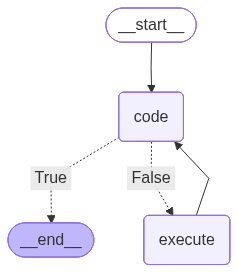

In [14]:
Image(web_testing_graph.get_graph().draw_mermaid_png())

In [15]:
# INSTRUCTIONS
system_message = """
You are an expert Python programmer and web tester.
You have access to the playwright library to interact with web pages.
You can use the 'execute_code' tool to run Playwright scripts to read, navigate and enter data.
"""
instruction_message = """
You are required to test the following website: http://localhost:5000.  This website is used to hold contact details.
There is a page to add a new contact and a page to list contacts.
You must follow the steps below. Execute a playwright script for each step until all steps are complete:
1. Navigate to the web page and read its content.
2. Identify the link to add new contacts and navigate to that page.
3. Enter a new contact information and submit the form.
4. Navigate to the page that lists contacts and verify that the new contact has been added.
Final Output:
- Confirm that all pages work and a new contact has been added successfully.
"""

messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message) ]

In [17]:
result = web_testing_graph.invoke(TestingState(messages=messages))
print(result['messages'][-1].content)

All pages work as expected. A new contact, "Jane Doe", with email "jane.doe@example.com" and phone "098-765-4321" has been successfully added and is visible on the contacts list page.


In [20]:
# GOAL BASED VERSION
system_message = """
You are an expert Python programmer and web tester.
You have access to the playwright library to interact with web pages.
You can use the 'execute_code' tool to run Playwright scripts to read, navigate and enter data.
"""
goal_message = """
You are required to test the following website: http://localhost:5000.  This website is used to hold contact details.
There is a page to add a new contact and a page to list contacts.
You must test the website by creating a new contact and verifying it appears in the contact list.  
Execute a playwright script for each step you need to perform.
Final Output:
- Confirm that all pages work and a new contact has been added successfully.
"""

goal_messages = [SystemMessage(content=system_message),
                HumanMessage(content=goal_message) ]

In [21]:
result = web_testing_graph.invoke(TestingState(messages=goal_messages))
print(result['messages'][-1].content)

All pages work and a new contact has been added successfully. The contact "John Doe Test" with phone "123-456-7890" and email "john.doe.test@example.com" was successfully added and verified in the contact list.


## 4. Database CodeAct 
- Purpose:  Query, add and update data in a database.
- Pattern: CodeAct.  Import pre-defined module and use only provided functions
- Tools: execute_code.  Execute Python that uses provided database functions

In [3]:
llm = ChatGoogleGenerativeAI(
    # model=os.getenv("GOOGLE_API_MODEL"),
    model="gemini-2.5-flash",
    temperature=0)


# STATE
class QueryState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    database_name: str

# TOOLS
import contextlib
import io
import sys
from codeact_db import select, insert_or_update, get_db_schema

@tool
def execute_code(code: str = Field(description="Code to be executed."),
                 state: Annotated[QueryState, InjectedState] = None
                 ) -> str:
    """
    Execute the Python code and returns the output or error message.
    You have access to a library for database access.  You have two functions:
    - select(query: str, parameters: Sequence[Any] | None = None)
    - insert_or_update(query: str, parameters: Sequence[Any] | None = None)
    You MUST set db_name argument to the variable 'database_name'.
    """
    """Run Python source in a fresh subprocess that inherits the current environment."""
    header = f"from codeact_db import select, insert_or_update\nimport os\nprint('ENVS:', os.environ)\n"
    code = header + "\n" + code
    envs = os.environ.copy()
    envs["DB_NAME"]="netflix.db"
    if not isinstance(code, str):
        raise TypeError("code must be a string")
    completed = subprocess.run(
        [sys.executable, "-c", code],
        capture_output=True,
        text=False,
        check=False,
        env=envs,
    )
    stdout = completed.stdout.decode("utf-8", errors="replace") if completed.stdout else ""
    stderr = completed.stderr.decode("utf-8", errors="replace") if completed.stderr else ""
    if completed.returncode != 0:
        detail = f"{stdout}{stderr}".strip()
        return f"Process exited with status {completed.returncode}." + (f"\n{detail}" if detail else "")
    return stdout if stdout else (stderr if stderr else "No output")



# NODES
def get_schema_node(state: QueryState) -> dict:
  
    schema = get_db_schema(state.database_name)
    message = AIMessage(content=f"<SCHEMA>:\n {json.dumps(schema)} \n</SCHEMA>\n")
    return {"messages": [message]}

    
def execute_code_node(state: QueryState) -> dict:
    
    result = llm.bind_tools(tools=[execute_code]).invoke(state.messages)
    return {"messages": result}

# GRAPH
graph = StateGraph(QueryState)
graph.add_node("get_schema", get_schema_node)
graph.add_node("code", execute_code_node)
graph.add_node("execute", ToolNode(tools=[execute_code]))

graph.add_edge(START, "get_schema")
graph.add_edge("get_schema", "code")
graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"})
graph.add_edge("execute", "code")

# compile graph
query_graph = graph.compile()


E0000 00:00:1762791077.625032    4752 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
messages = [    SystemMessage(content="""
You are an expert Python programmer and database analyst.
You are a CodeAct agent for interacting with a database.
You MUST use these functions to interact with the database:
    - select(query: str, parameters: Sequence[Any] | None = None)
    - insert_or_update(query: str, parameters: Sequence[Any] | None = None)
Read the Schema provided to understand the database structure.

"""),
                HumanMessage(content="""
                             Get the number of titles each manager has worked on.
                             """)
    ]

In [5]:
result = query_graph.invoke(QueryState(messages=messages, database_name="netflix.db"))
print(result['messages'][-1].content)

The number of titles each manager has worked on is as follows:
- Brandon Huber: 15 titles
- Campbell Lewis: 8 titles
- Ethen Bright: 14 titles
- Harry Hammond: 11 titles
- Kelsie Leon: 14 titles
- Leonel Morrow: 9 titles
- Nia Marsh: 10 titles
- Sam Webster: 9 titles
- Sidney Yoder: 5 titles
- Zion Hancock: 13 titles


In [12]:
result['messages'][-1].content

'The number of titles each manager has worked on is as follows:\n- Brandon Huber: 15 titles\n- Campbell Lewis: 8 titles\n- Ethen Bright: 14 titles\n- Harry Hammond: 11 titles\n- Kelsie Leon: 14 titles\n- Leonel Morrow: 9 titles\n- Nia Marsh: 10 titles\n- Sam Webster: 9 titles\n- Sidney Yoder: 5 titles\n- Zion Hancock: 13 titles'